# an emission spectrum  check CO



In [4]:
#
#   Current Status: Feb. 25th (2021)
#
#   OK: forward JVP / HML RT alpha as a free parameter
#   Not work: primitive backward / alpha as a free parameter
#   Not implemented yet: VJP backward (something wrong for NumPyro) 
#
#   Current fiducial model: forward JVP
#   Updates: rtransfer class (Feb.25/2021)
#
#   ToDo:
#   Q(T) TIPS
# 

In [2]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import rtransfer as rt
from exojax.spec import planck
from exojax.spec import moldb
from exojax.spec import make_numatrix0,xsvector
from exojax.spec.lpf import xsmatrix
from exojax.spec.clpf import cxsmatrix
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.plot.atmplot import plottau, plotcf
from exojax.spec.rtransfer import rtrun, dtaux 
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import jax.numpy as jnp
from jax import random
from jax import vmap, jit
plt.style.use('bmh')

## INPUT MODEL

In [7]:
N=400
wav=np.linspace(22945,22985,N,dtype=np.float64)#AA
#N=1400
#wav=np.linspace(22945,23055,N,dtype=np.float64)#AA
nus=1.e8/wav[::-1]

alpha_in=0.02
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = 1500.*(Parr/Parr[-1])**alpha_in

#loading molecular database (HITRAN2012/CO)
mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2010.par',nus)
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2019.par',nus)

In [8]:
#partition function ratio
#mdbCO_HITRAN=moldb.MdbHit('/home/kawahara/exojax/data/CO','05_hit12',nus)
mdbCO_hitran=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
qt=mdbCO_hitran.Qr_layer(Tarr)

In [9]:
from scipy.constants import  m_u
mmw=2.33 #mean molecular weight
molmass=28.01 #molecular mass
MMR=0.01*np.ones_like(Tarr) #mass mixing ratio
g=1.e5 # gravity cm/s2

Xco=MMR*mmw/molmass #VMR

In [10]:
SijM=vmap(SijT,(0,None,None,None,0))(Tarr,mdbCO.logsij0,mdbCO.nu_lines\
                                          ,mdbCO.elower,qt)
gammaLM = vmap(gamma_hitran,(0,0,0,None,None,None))\
(Parr,Tarr,Parr*Xco, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
+ gamma_natural(mdbCO.A) #uncomment if you inclide a natural width
sigmaDM=vmap(doppler_sigma,(None,0,None))(mdbCO.nu_lines,Tarr,molmass)

In [11]:
nu0=mdbCO.nu_lines
numatrix=make_numatrix0(nus,nu0)
xsm=xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

## cheking d tau and contribution function

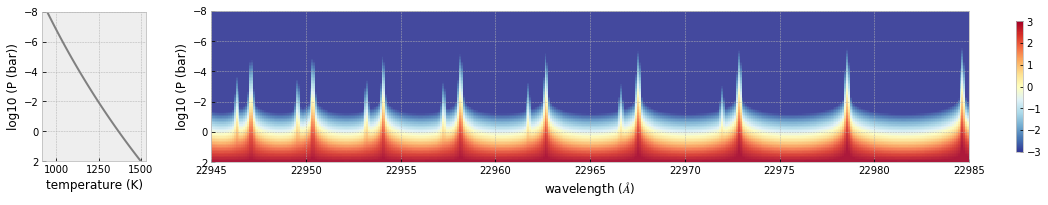

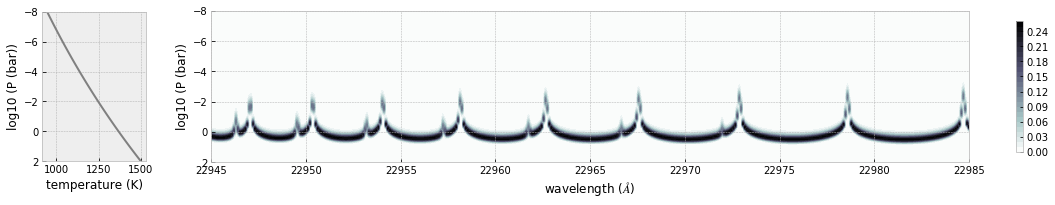

In [12]:
dtauM=dtaux(dParr,xsm,MMR,mmw,g)
plottau(nus,dtauM,Tarr,Parr,unit="AA") #tau
plotcf(nus,dtauM,Tarr,Parr,dParr,unit="AA") 

In [13]:
sourcef=planck.piBarr(Tarr,nus)

In [14]:
Fx0=rtrun(dtauM,sourcef)

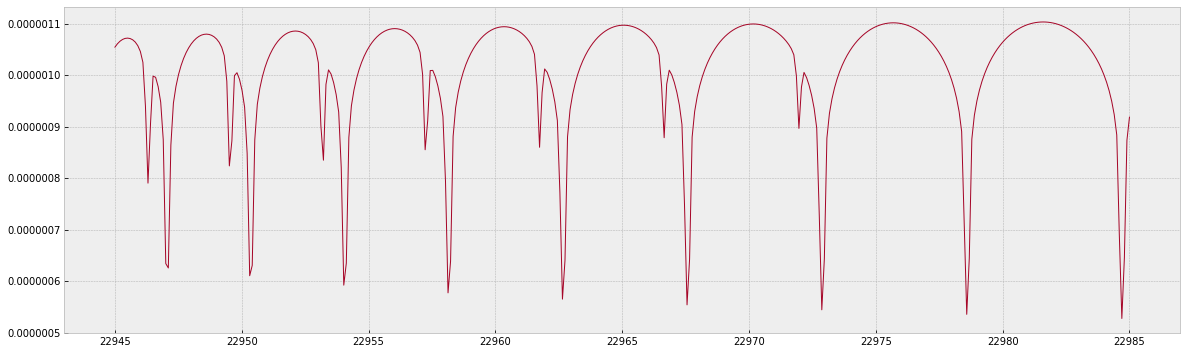

In [15]:
fig=plt.figure(figsize=(20,6.0))
plt.plot(wav[::-1],Fx0,lw=1,color="C1")
plt.savefig("highredCO.png")

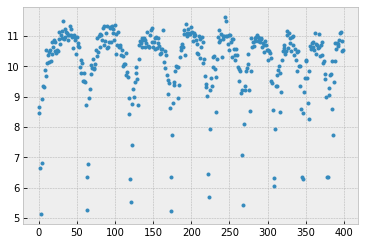

In [16]:
intfac=1.e7
sigin=0.25
N=len(Fx0)
data=Fx0*intfac+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [17]:
vgamma_hitran=jit(vmap(gamma_hitran,(0,0,0,None,None,None)))
vdoppler_sigma=jit(vmap(doppler_sigma,(None,0,None)))
vSij=jit(vmap(SijT,(0,None,None,None,0)))

In [18]:
import arviz
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

/home/kawahara/anaconda3/lib/python3.7/site-packages/distributed/utils.py:139: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [19]:
### class version
def model_c(nu,y):
    A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sigma = numpyro.sample('sigma', dist.Exponential(0.3))
    nu0 = numpyro.sample('nu0', dist.Uniform(-0.3,0.3))
    alpha = numpyro.sample('alpha', dist.Uniform(0.019,0.021))

    #T-P model
    Tarr = 1500.*(Parr/Parr[-1])**alpha 
    
    #line computation
    SijM=vSij(Tarr,mdbCO.logsij0,mdbCO.dev_nu_lines,mdbCO.elower,qt)
    gammaLM = vgamma_hitran(Parr,Tarr,Parr*Xco,\
                            mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self) \
                            + mdbCO.gamma_natural 
    sigmaDM=vdoppler_sigma(mdbCO.dev_nu_lines,Tarr,molmass)
    sourcef = planck.piBarr(Tarr,nus)
    
    xsm=cxsmatrix(numatrix-nu0,sigmaDM,gammaLM,SijM)   
    dtauM=dtaux(dParr,xsm,MMR,mmw,g)
    
    mu=rtrun(dtauM,sourcef)
    mu=intfac*A*mu
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [21]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200

kernel = NUTS(model_c,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nus, y=data)
mcmc.print_summary()

sample: 100%|██████████| 300/300 [19:52<00:00,  1.45s/it, 23 steps of size 6.60e-02. acc. prob=0.95]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      1.01      0.01      1.01      1.00      1.02     26.10      1.01
     alpha      0.02      0.00      0.02      0.02      0.02     24.45      1.00
       nu0      0.00      0.00      0.00     -0.00      0.00     86.19      1.03
     sigma      0.24      0.01      0.24      0.22      0.25    194.15      1.00

Number of divergences: 0


In [23]:
posterior_sample = mcmc.get_samples()
pred = Predictive(model_c,posterior_sample)
nu_ = nus
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)

In [24]:
hpdi_mu = hpdi(predictions["y"], 0.9)

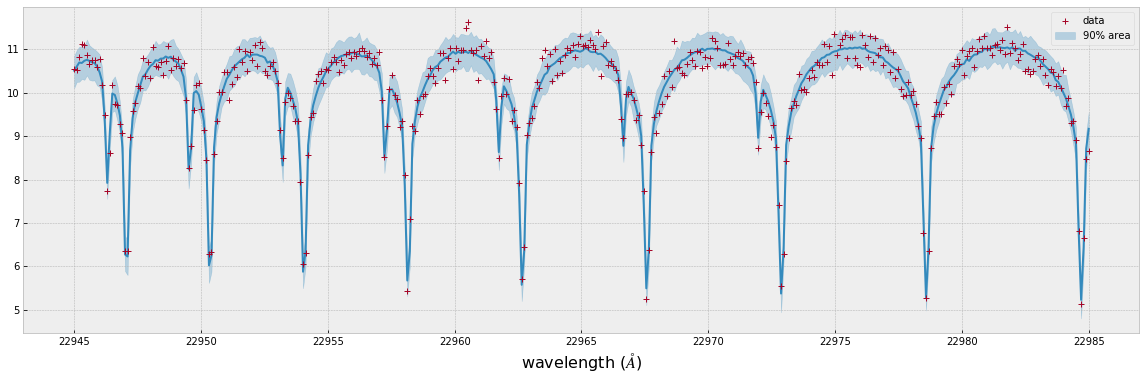

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))


#plt.plot(wav[::-1],Fx0,lw=1,color="C1",label="in")
ax.plot(wav[::-1],median_mu,color="C0")
ax.plot(wav[::-1],data,"+",color="C1",label="data")
ax.fill_between(wav[::-1], hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_CO_emission.png")
plt.show()

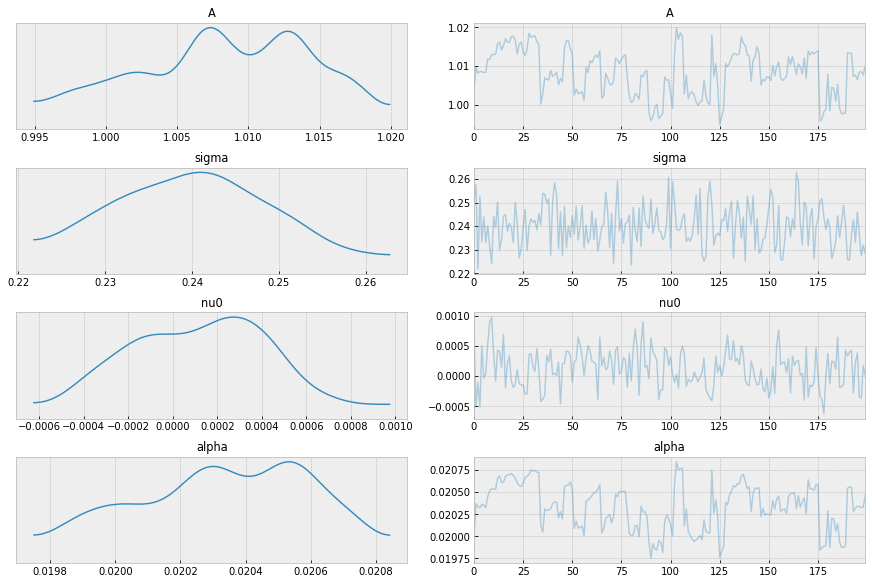

In [26]:
import arviz
arviz.plot_trace(mcmc, var_names=["A","sigma","nu0","alpha"])
plt.show()

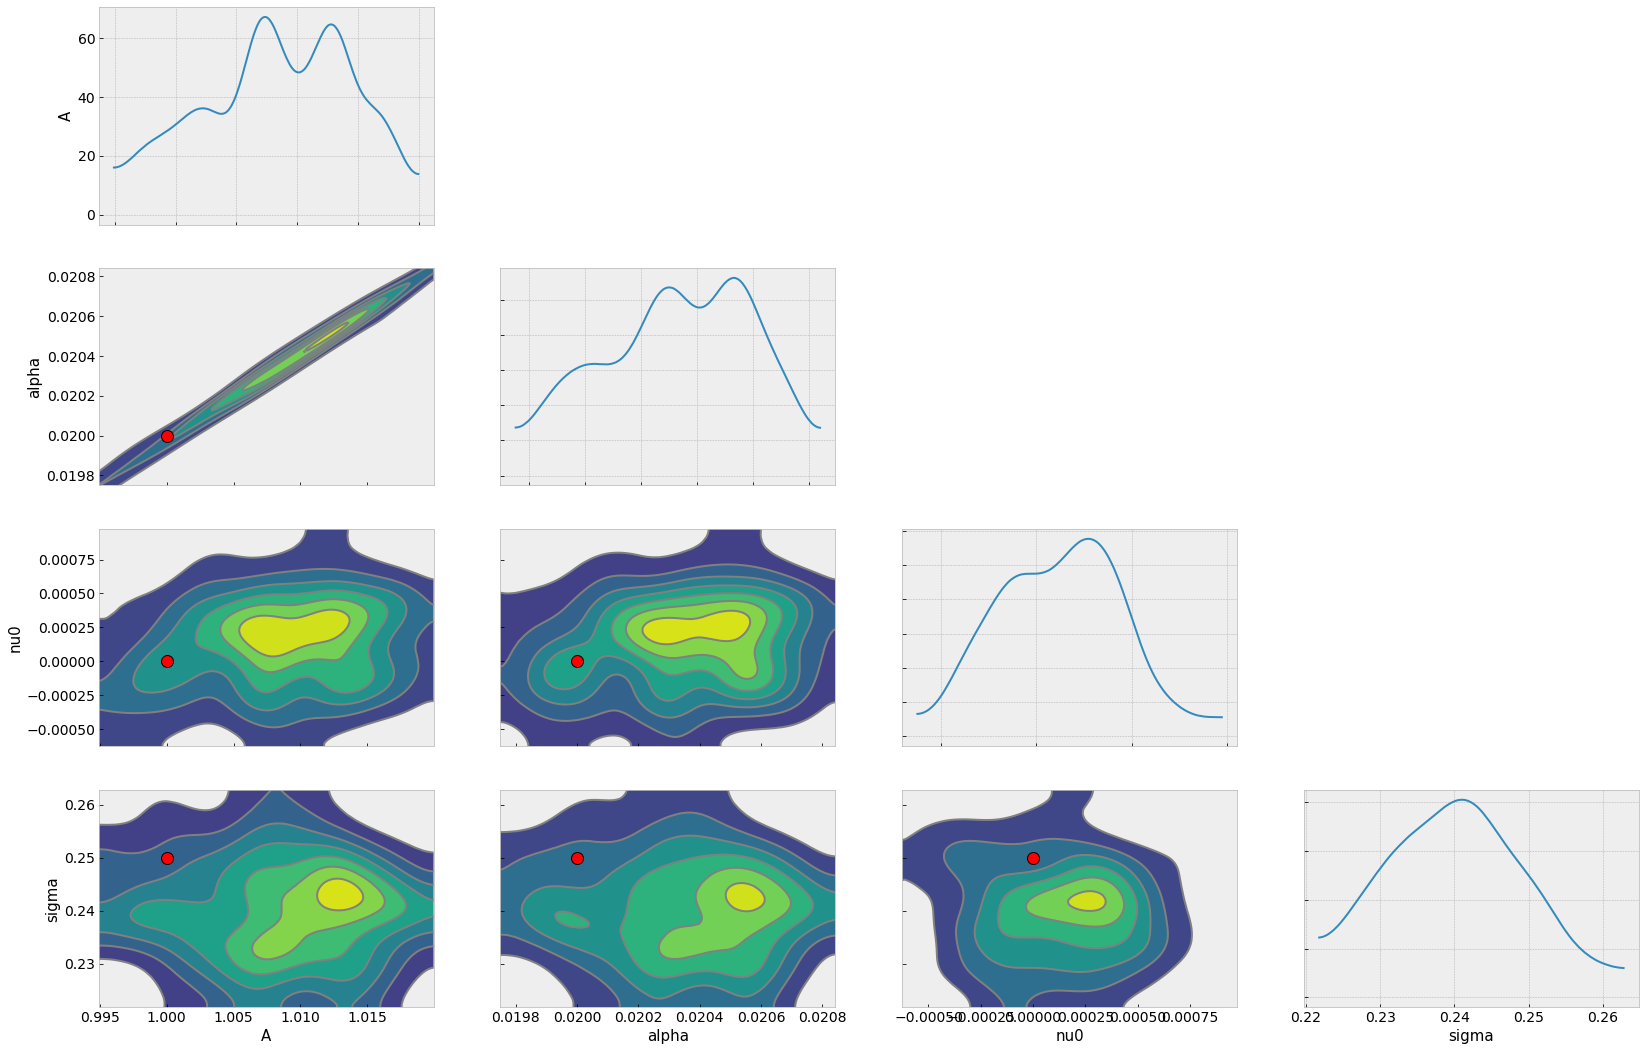

In [27]:
refs={}
refs["A"]=1.0
#refs["sD"]=sDfix
#refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=0.0
refs["alpha"]=0.02
#refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("../../documents/figures/posterior_CO.png")
plt.show()

In [70]:
Tarrx = 1500.*(device_relative_Parr[:,None])**posterior_sample["alpha"]

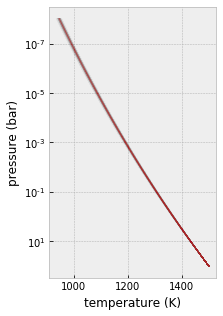

In [84]:
fig=plt.figure(figsize=(3,5))
for i in range(len(posterior_sample["alpha"])):
    plt.plot(Tarrx[:,i],Parr,alpha=0.005,color="C1")
plt.yscale("log")
plt.gca().invert_yaxis()
#plt.xscale("log")
plt.xlabel("temperature (K)")
plt.ylabel("pressure (bar)")
plt.savefig("../../documents/figures/TP_CO.png")
plt.show()